<a href="https://colab.research.google.com/github/mahenoor22/skin-disease-build/blob/main/model_build/CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from keras.datasets import mnist
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from typing import Optional
from kaggle.api.kaggle_api_extended import KaggleApi
from PIL import Image
!chmod 600 /content/kaggle.json

In [6]:
os.environ['KAGGLE_CONFIG_DIR']='/content'
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.19G/5.20G [01:13<00:00, 140MB/s]
100% 5.20G/5.20G [01:13<00:00, 76.2MB/s]


In [7]:
!unzip \*.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

In [2]:
train_dir = r"/content/base_dir/base_dir/train_dir"
test_dir=r"/content/base_dir/base_dir/val_dir"

In [8]:
data = pd.read_csv('/content/hmnist_28_28_RGB.csv')

X = data.drop(columns='label')/255
Y = data['label']

num_rows, num_cols = 28, 28
num_classes = len(set(Y))

X = np.array(X)
X = X.reshape(X.shape[0], num_rows, num_cols, 3)

Y = np.eye(num_classes)[np.array(Y.astype(int)).reshape(-1)]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
#Split the dataset into 80% training and 20% test

X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.10, random_state=42)


In [9]:
base_skin_dir = os.path.join('..', '/content')
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [10]:
skin_data = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
skin_data['path'] = skin_data['image_id'].map(imageid_path_dict.get)
skin_data['cell_type'] = skin_data['dx'].map(lesion_type_dict.get) 
skin_data['cell_type_idx'] = pd.Categorical(skin_data['cell_type']).codes
skin_data.sample(3)
skin_data.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [11]:
skin_data['age'].fillna((skin_data['age'].mean()), inplace=True)
#Replace null age with mean age

skin_data['image'] = skin_data['path'].map(lambda x: np.asarray(Image.open(x).resize((28,28))))

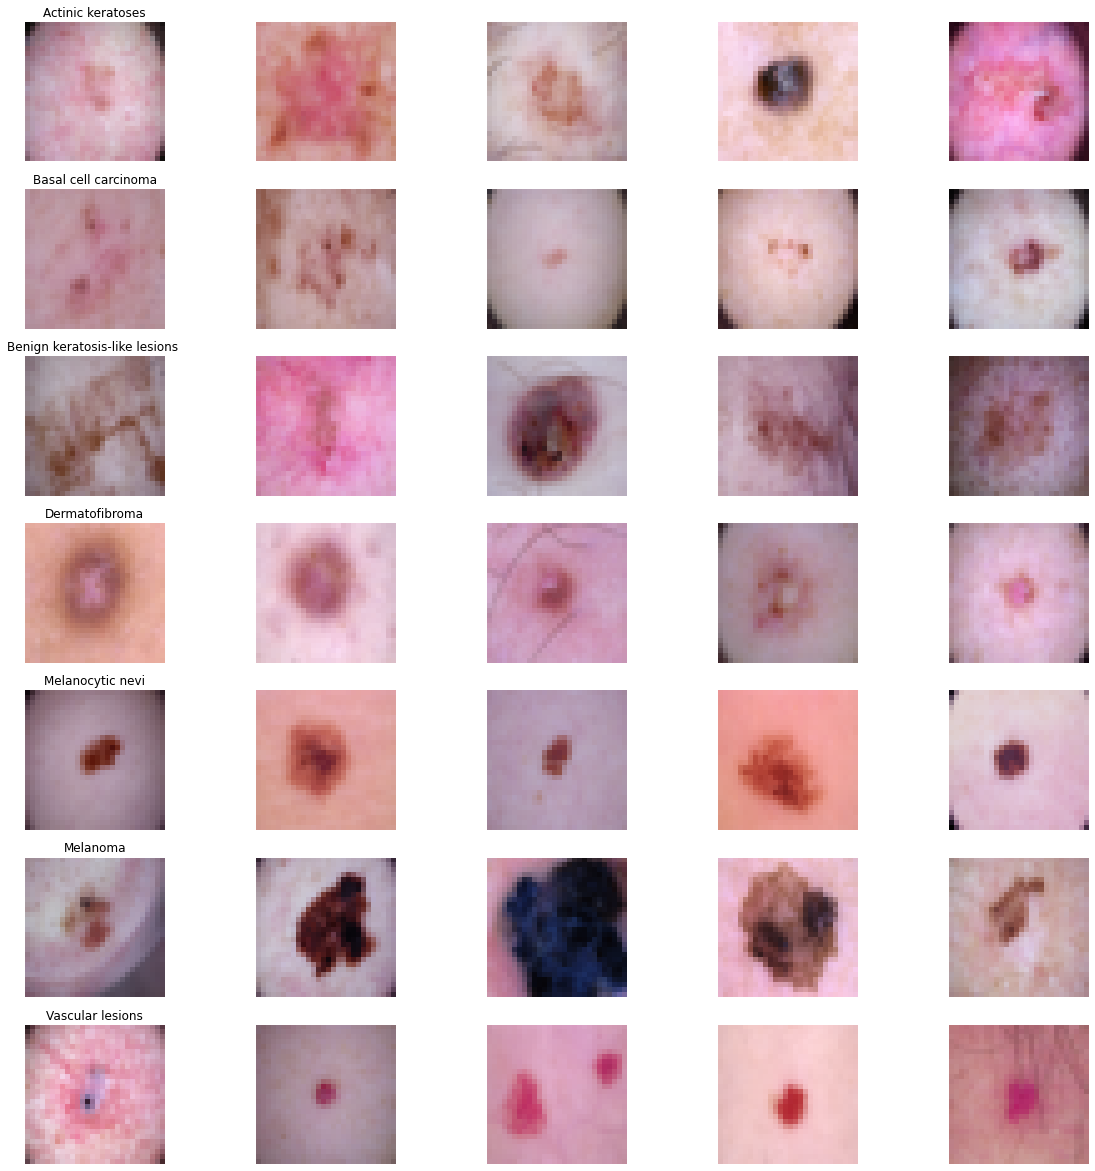

In [12]:

n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_data.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=6542).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [13]:
skin_data['image'].map(lambda x: x.shape).value_counts()


(28, 28, 3)    10015
Name: image, dtype: int64

In [14]:
input_shape = (28, 28, 3)
num_classes = 7
model = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', input_shape=input_shape),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),

    Conv2D(64, 3, padding='same', activation='relu', input_shape=input_shape),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.4),
    
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.5),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.55),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

In [15]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=False,  
        vertical_flip=False)  
datagen.fit(X_train)

In [17]:

epochs = 30
batch_size = 100
history = model.fit_generator(
    datagen.flow(X_train,y_train, batch_size=batch_size),
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(X_validate,y_validate),
    validation_steps=X_validate.shape[0] // batch_size
    ,callbacks=[learning_rate_reduction]
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
72/72 [==============================] - 35s 489ms/step - loss: 0.2458 - accuracy: 0.6707 - val_loss: 0.2386 - val_accuracy: 0.6596
Epoch 2/30
72/72 [==============================] - 35s 481ms/step - loss: 0.2343 - accuracy: 0.6724 - val_loss: 0.2269 - val_accuracy: 0.6596
Epoch 3/30
72/72 [==============================] - 37s 508ms/step - loss: 0.2244 - accuracy: 0.6719 - val_loss: 0.2172 - val_accuracy: 0.6596
Epoch 4/30
72/72 [==============================] - 35s 491ms/step - loss: 0.2186 - accuracy: 0.6737 - val_loss: 0.2117 - val_accuracy: 0.6820
Epoch 5/30
72/72 [==============================] - 35s 483ms/step - loss: 0.2170 - accuracy: 0.6786 - val_loss: 0.2087 - val_accuracy: 0.6820
Epoch 6/30
72/72 [==============================] - 35s 482ms/step - loss: 0.2100 - accuracy: 0.6840 - val_loss: 0.2099 - val_accuracy: 0.6733
Epoch 7/30
72/72 [==============================] - 35s 483ms/step - loss: 0.2072 - accuracy: 0.6776 - val_loss: 0.2083 - val_accuracy: 0.6683

In [18]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

63/63 [==============================] - 2s 38ms/step - loss: 0.1845 - accuracy: 0.7394
Test: accuracy = 0.739391  ;  loss = 0.184481


## **SAVE AND LOAD MODEL**

In [19]:
if os.path.isfile('/content/model_build/CNN_model.h5') is False:
  model.save('model_build/CNN_model.h5')

In [20]:
from tensorflow.keras.models import load_model
new_model=load_model("model_build/CNN_model.h5")

In [21]:
new_model.summary()
new_model.get_weights()
new_model.optimizer

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

## **MODEL to Json**

In [23]:
#save as JSON
json_string=model.to_json()

json_string
from tensorflow.keras.models import model_from_json
model_arch=model_from_json(json_string)
model_arch.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

In [31]:
import numpy as np
from keras.preprocessing import image

img_width, img_height = 28,28
img = image.load_img('/content/ISIC_0027008.jpg', target_size = (img_width, img_height))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)
model.predict(img)


array([[0., 0., 0., 0., 1., 0., 0.]], dtype=float32)